In [1]:
import numpy as np
from collections import defaultdict, Counter
from itertools import product
import json
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy.stats

In [2]:
chroms = [str(i) for i in range(1, 23)]
gens = ['0/0', '0/1', '1/1']
obss = ['0/0', '0/1', '1/1', './.']

# First, check twins

In [3]:
def pull_baseline_counts(data_dir):
    sample_to_chroms = defaultdict(set)
    sample_to_family = dict()
    family_to_size = dict()
    baseline_counts = defaultdict(lambda: np.zeros((len(obss),)))
    children, moms, dads = set(), set(), set()
    
    # pull counts from famgen
    for i, chrom in enumerate(chroms):
        print(chrom, end=' ')

        with open('%s/chr.%s.famgen.counts.txt' % (data_dir, chrom), 'r') as f:
            for line in f:
                pieces = line.strip().split('\t')
                famkey, inds = pieces[:2]
                #famkey = famkey.split('.')[0]

                if 'ssc' in data_dir:
                    # unfortunately, ssc uses . in their sample names
                    inds = inds.split('.')
                    inds = ['%s.%s' % (inds[i], inds[i+1]) for i in range(0, len(inds), 2)]
                else:
                    inds = inds.split('.')
                    
                m = len(inds)
                family_to_size[famkey] = m
                for ind in inds:
                    sample_to_chroms[ind].add(chrom)
                    sample_to_family[ind] = famkey

                for g, c in zip(product([0, 1, 2, 3], repeat=m), pieces[2:]):
                    for j, ind in enumerate(inds):
                        baseline_counts[ind][g[j]] += int(c)

                moms.add(inds[0])
                dads.add(inds[1])
                children.update(inds[2:])    
            
    multigen = children & (moms | dads)
    print('\nRemoving %d individuals involved in multiple generations' % len(multigen))
    
    missing_chroms = set([x for x, chrs in sample_to_chroms.items() if len(chrs) != len(chroms)])
    print('Removing %d individuals missing chromosomal data' % len(missing_chroms))
    
    children = children - multigen - missing_chroms
    moms = moms - multigen - missing_chroms
    dads = dads - multigen - missing_chroms
    
    samples = sorted(children | moms | dads)
    families = [sample_to_family[x] for x in samples]
    family_sizes = np.array([family_to_size[x] for x in families])
    baseline_counts = np.array([baseline_counts[x] for x in samples])
    is_child = np.array([x in children for x in samples])
    is_mom = np.array([x in moms for x in samples])
    is_dad = np.array([x in dads for x in samples])
    
    return baseline_counts, samples, families, family_sizes, is_child, is_mom, is_dad

ihart_baseline_counts, ihart_samples, ihart_families, ihart_family_sizes, ihart_is_child, ihart_is_mom, ihart_is_dad = pull_baseline_counts('../split_gen_ihart_HCR001_split_identicals')
spark_exome_baseline_counts, spark_exome_samples, spark_exome_families, spark_exome_family_sizes, spark_exome_is_child, spark_exome_is_mom, spark_exome_is_dad = pull_baseline_counts('../split_gen_spark_exome_split_identicals')
spark_baseline_counts, spark_samples, spark_families, spark_family_sizes, spark_is_child, spark_is_mom, spark_is_dad = pull_baseline_counts('../split_gen_spark_split_identicals')


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data


In [4]:
def pull_error_rates(samples, families, param_file):
    
    with open(param_file, 'r') as f:
        params = json.load(f)
    
    rates = np.zeros((len(samples), len(gens), len(obss)))
    rates[:] = np.nan
                
    for i, (sample_id, family) in enumerate(zip(samples, families)):
        key = '%s.%s' % (family, sample_id)
        if key in params:
            rates[i, :, :] = [[params[key]['-log10(P[obs=%s|true_gen=%s])' % (o, g)] for o in obss] for g in gens]
        
    return rates

ihart_error_rates = pull_error_rates(ihart_samples, ihart_families, 'ihart_HCR001_split_identicals_ind_pass_nodel_params.json')
spark_exome_error_rates = pull_error_rates(spark_exome_samples, spark_exome_families, 'spark_exome_split_identicals_ind_pass_nodel_params.json')
spark_error_rates = pull_error_rates(spark_samples, spark_families, 'spark_split_identicals_ind_pass_nodel_params.json')



In [5]:
def estimate_error_counts(baseline_counts, error_rates):
    m = error_rates.shape[0]
    expected_error_counts = np.zeros((m, len(gens), len(obss)))
    
    fill_in_values = np.nanmedian(10.0**-error_rates, axis=0).T
    
    for i in range(m):
        #X = 10.0**-error_rates[i, :, :].T
        #if np.any(np.isnan(X)):
        #    X[np.isnan(X)] = fill_in_values[np.isnan(X)]
        #    X[0, 0] = 1-np.sum(X[[1, 2, 3], 0])
        #    X[1, 1] = 1-np.sum(X[[0, 2, 3], 1])
        #    X[2, 2] = 1-np.sum(X[[0, 1, 3], 2])
        #y = baseline_counts[i, :]
        #ground_truth = np.linalg.lstsq(X, y, rcond=None)[0]
        
        ground_truth = baseline_counts[i, :3]
        
        for gen_index, obs_index in product(range(len(gens)), range(len(obss))):
            expected_error_counts[i, gen_index, obs_index] = ground_truth[gen_index]*(10**-error_rates[i, gen_index, obs_index])
    return expected_error_counts

ihart_error_counts = estimate_error_counts(ihart_baseline_counts, ihart_error_rates)
spark_exome_error_counts = estimate_error_counts(spark_exome_baseline_counts, spark_exome_error_rates)
spark_error_counts = estimate_error_counts(spark_baseline_counts, spark_error_rates)


In [7]:
def pull_twins(twin_file, data_dir, samples):
    twin_pairs = []
    with open(twin_file, 'r') as f:
        for line in f:
            individuals = [x.split('_')[-1] for x in line.strip().split('\t') if 'LCL' not in x]
            individuals = [x for x in individuals if x in samples]
            if len(individuals) == 2:
                twin_pairs.append(tuple(individuals))
                
    # twin1, twin2
    counts = np.zeros((len(twin_pairs), 4, 4), dtype=int)
    
    famkeys = [None for _ in twin_pairs]
    for i, chrom in enumerate(chroms):
        print(chrom, end=' ')

        with open('%s/chr.%s.famgen.counts.txt' % (data_dir, chrom), 'r') as f:
            for line in f:
                pieces = line.strip().split('\t')
                fk, inds = pieces[:2]
                inds = inds.split('.')
                
                for twinpair_index, (twin1, twin2) in enumerate(twin_pairs):
                    if twin1 in inds and twin2 in inds:
                        famkeys[twinpair_index] = fk
                        ind_to_index = dict([(x, i) for i, x in enumerate(inds)])

                        for g, c in zip(product([0, 1, 2, 3], repeat=len(inds)), pieces[2:]):
                            counts[twinpair_index, g[ind_to_index[twin1]], g[ind_to_index[twin2]]] += int(c)
    return twin_pairs, counts

ihart_twins, ihart_twin_counts = pull_twins('../sibpair_similarity/ihart_identicals.txt', '../split_gen_ihart_HCR', ihart_samples)
spark_exome_twins, spark_exome_twin_counts = pull_twins('../sibpair_similarity/spark_exome_identicals.txt', '../split_gen_spark_exome', spark_exome_samples)
spark_twins, spark_twin_counts = pull_twins('../sibpair_similarity/spark_identicals.txt', '../split_gen_spark', spark_samples)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [8]:
mismatches = [('0/0', '0/1'), ('0/0', '1/1'), ('0/1', '1/1'),
             ('0/0', './.'), ('0/1', './.'), ('1/1', './.')]

def twin_expected_vs_observed(twins, samples, family_sizes, error_counts, twin_counts, error_rates):
    print(mismatches)
    # first expected
    expected = np.zeros((2*len(twins), len(mismatches)))
    observed = np.zeros((2*len(twins), len(mismatches)))
    famsize = np.zeros((2*len(twins),))
    
    for i, (twin1, twin2) in enumerate(twins):
        twin1_index, twin2_index = samples.index(twin1), samples.index(twin2)
        for j, (obs1, obs2) in enumerate(mismatches):
            
            # expected
            obs1_index, obs2_index = obss.index(obs1), obss.index(obs2)
            # obs1 is correct, obs2 is the error
            if obs1 in gens:
                expected[2*i, j] = error_counts[twin2_index, obs1_index, obs2_index]
                expected[(2*i)+1, j] = error_counts[twin1_index, obs1_index, obs2_index]
            # obs2 is correct, obs1 is the error
            if obs2 in gens:
                expected[2*i, j] += error_counts[twin1_index, obs2_index, obs1_index]
                expected[(2*i)+1, j] += error_counts[twin2_index, obs2_index, obs1_index]
    
            # observed
            observed[2*i, j] = twin_counts[i, obs1_index, obs2_index]
            observed[(2*i)+1, j] = twin_counts[i, obs2_index, obs1_index]
            
        famsize[2*i] = family_sizes[twin1_index]
        famsize[(2*i) + 1] = family_sizes[twin2_index]
        
        assert family_sizes[twin1_index] == family_sizes[twin2_index]
    
    return expected, observed, famsize

ihart_twins_expected, ihart_twins_observed, ihart_twins_famsize = twin_expected_vs_observed(ihart_twins, ihart_samples, ihart_family_sizes, ihart_error_counts, ihart_twin_counts, ihart_error_rates)
spark_exome_twins_expected, spark_exome_twins_observed, spark_exome_twins_famsize = twin_expected_vs_observed(spark_exome_twins, spark_exome_samples, spark_exome_family_sizes, spark_exome_error_counts, spark_exome_twin_counts, spark_exome_error_rates)
spark_twins_expected, spark_twins_observed, spark_twins_famsize = twin_expected_vs_observed(spark_twins, spark_samples, spark_family_sizes, spark_error_counts, spark_twin_counts, spark_error_rates)



[('0/0', '0/1'), ('0/0', '1/1'), ('0/1', '1/1'), ('0/0', './.'), ('0/1', './.'), ('1/1', './.')]
[('0/0', '0/1'), ('0/0', '1/1'), ('0/1', '1/1'), ('0/0', './.'), ('0/1', './.'), ('1/1', './.')]
[('0/0', '0/1'), ('0/0', '1/1'), ('0/1', '1/1'), ('0/0', './.'), ('0/1', './.'), ('1/1', './.')]


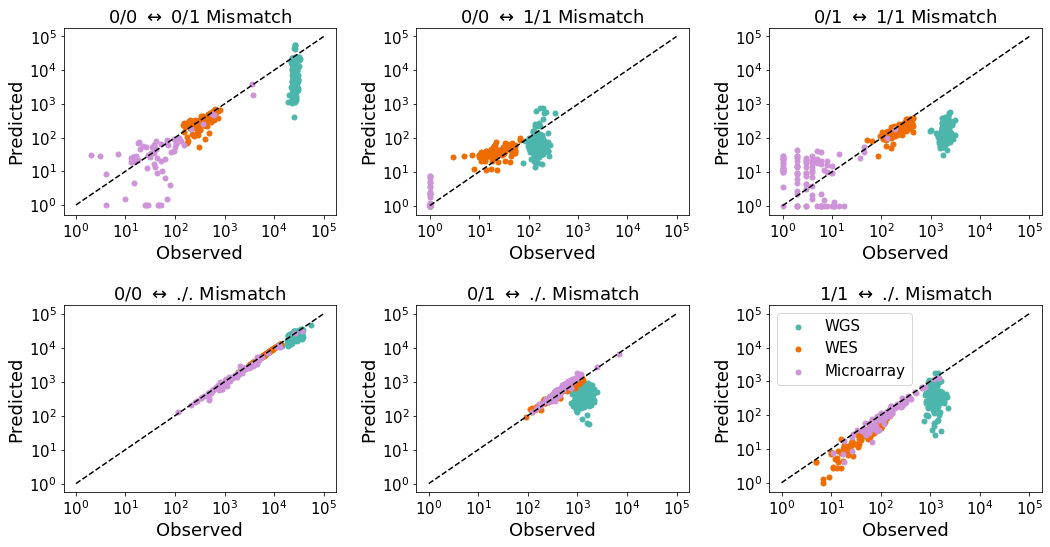

In [9]:
plt.rcParams.update({'font.size': 20})


plt.figure(figsize=(15, 8))
for i, (obs1, obs2) in enumerate(mismatches):
    plt.subplot(2, 3, i+1)
    plt.title(r'%s $\leftrightarrow$ %s Mismatch' % (obs1, obs2), fontsize=18)
    
    plt.scatter(np.log10(np.clip(ihart_twins_observed[:, i], 1, None)), 
                np.log10(np.clip(ihart_twins_expected[:, i], 1, None)),
                color='#4db6ac', label='WGS', marker='.', s=100)
    
    plt.scatter(np.log10(np.clip(spark_exome_twins_observed[:, i], 1, None)), 
                np.log10(np.clip(spark_exome_twins_expected[:, i], 1, None)),
                color='#ef6c00', label='WES', marker='.', s=100)
    #plt.scatter(np.log10(np.clip(spark_exome_twins_observed[spark_exome_twins_famsize==3, i], 1, None)), 
    #            np.log10(np.clip(spark_exome_twins_expected[spark_exome_twins_famsize==3, i], 1, None)),
    #            color='#ef6c00', marker='x', s=100)
    
    plt.scatter(np.log10(np.clip(spark_twins_observed[:, i], 1, None)), 
                np.log10(np.clip(spark_twins_expected[:, i], 1, None)),
                color='#ce93d8ff', label='Microarray', marker='.', s=100)
    #plt.scatter(np.log10(np.clip(spark_twins_observed[spark_twins_famsize==3, i], 1, None)), 
    #            np.log10(np.clip(spark_twins_expected[spark_twins_famsize==3, i], 1, None)),
    #            color='#ce93d8ff', label='Microarray', marker='x', s=100)

    plt.plot([0, 5], [0, 5], color='black', linestyle='--')
    plt.xticks(range(6), ['$10^%d$' % d for d in range(6)], fontsize=15)
    plt.yticks(range(6), ['$10^%d$' % d for d in range(56)], fontsize=15)
    plt.xlabel('Observed', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    
    if i==5:
        plt.legend(fontsize=15)
        
        
plt.tight_layout()
plt.show()



# Compare LCL/WB

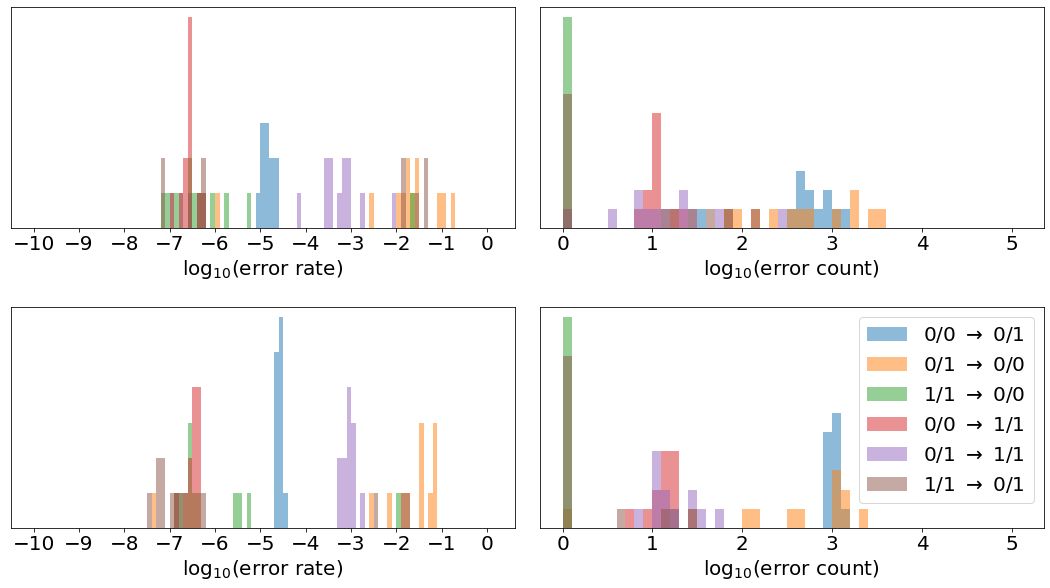

In [10]:
lcl_samples = sorted(set([x for x in ihart_samples if 'LCL' in x]))
wb_samples = sorted(set([x[:-4] for x in lcl_samples]))
is_lcl = [ihart_samples.index(x) for x in lcl_samples]
is_wb = [ihart_samples.index(x) for x in wb_samples]

plt.figure(figsize=(15, 12))

plt.subplot(3, 2, 1)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.hist(-np.clip(ihart_error_rates[is_lcl, gens.index(g), obss.index(o)], 0, 10), 
             bins=np.arange(-10, 0.2, 0.1), label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5, density=True)

    plt.xlabel('$\log_{10}$(error rate)')
    plt.yticks([], [])
    plt.xticks(np.arange(-10, 1))
    
plt.subplot(3, 2, 2)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.hist(np.clip(np.log10(ihart_error_counts[is_lcl, gens.index(g), obss.index(o)]), 0, 5), 
             bins=np.arange(0, 5.2, 0.1), label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5, density=True)

    plt.xlabel('$\log_{10}$(error count)')
    plt.yticks([], [])
    plt.xticks(np.arange(6))
    
plt.subplot(3, 2, 3)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.hist(-np.clip(ihart_error_rates[is_wb, gens.index(g), obss.index(o)], 0, 10), 
             bins=np.arange(-10, 0.2, 0.1), label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5, density=True)
    plt.xlabel('$\log_{10}$(error rate)')
    plt.yticks([], [])
    plt.xticks(np.arange(-10, 1))
    
plt.subplot(3, 2, 4)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.hist(np.clip(np.log10(ihart_error_counts[is_wb, gens.index(g), obss.index(o)]), 0, 5), 
             bins=np.arange(0, 5.2, 0.1), label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5, density=True)

    plt.xlabel('$\log_{10}$(error count)')
    plt.yticks([], [])
    plt.xticks(np.arange(6))


plt.legend()    
plt.tight_layout()
plt.show()



* 0/0 0/1 2.7081338577988976e-05
 0/1 0/0 0.619950636513121
 1/1 0/0 0.6614275851179822
 0/0 1/1 0.23582361617383932
 0/1 1/1 0.5911254004257698
 1/1 0/1 0.0687204020035427


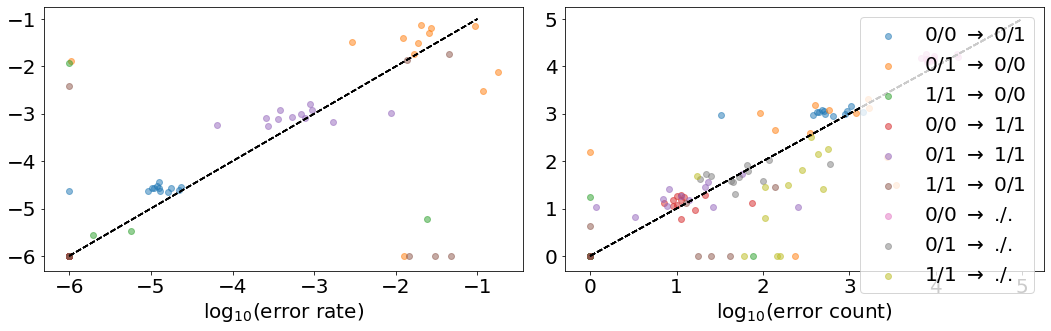

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.scatter(-np.clip(ihart_error_rates[is_lcl, gens.index(g), obss.index(o)], 0, 6), 
                -np.clip(ihart_error_rates[is_wb, gens.index(g), obss.index(o)], 0, 6),
                label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5)
    
    #print(g, o, scipy.stats.ttest_rel(10.0**-ihart_error_rates[is_lcl, gens.index(g), obss.index(o)],
    #                           10.0**-ihart_error_rates[is_wb, gens.index(g), obss.index(o)]))
    test = scipy.stats.ttest_rel(ihart_error_rates[is_lcl, gens.index(g), obss.index(o)],
                               ihart_error_rates[is_wb, gens.index(g), obss.index(o)])
    print('*' if test.pvalue*9 < 0.05 else '', g, o, test.pvalue)
    plt.xlabel('$\log_{10}$(error rate)')
    plt.xticks(np.arange(-6, 0))
    plt.plot(np.arange(-6, 0), np.arange(-6, 0), color='black', linestyle='--')


plt.subplot(1, 2, 2)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            ('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.scatter(np.clip(np.log10(ihart_error_counts[is_lcl, gens.index(g), obss.index(o)]), 0, 5), 
                np.clip(np.log10(ihart_error_counts[is_wb, gens.index(g), obss.index(o)]), 0, 5), 
             label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5)

    plt.xlabel('$\log_{10}$(error count)')
    plt.xticks(np.arange(6))
    plt.plot(np.arange(6), np.arange(6), color='black', linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()



# Population distributions

In [ ]:
ihart_baseline_counts, ihart_samples, ihart_families, ihart_family_sizes, ihart_is_child, ihart_is_mom, ihart_is_dad = pull_baseline_counts('../split_gen_ihart')
spark_exome_baseline_counts, spark_exome_samples, spark_exome_families, spark_exome_family_sizes, spark_exome_is_child, spark_exome_is_mom, spark_exome_is_dad = pull_baseline_counts('../split_gen_spark_exome_EX')
spark_baseline_counts, spark_samples, spark_families, spark_family_sizes, spark_is_child, spark_is_mom, spark_is_dad = pull_baseline_counts('../split_gen_spark')



In [ ]:
ihart_error_rates = pull_error_rates(ihart_samples, ihart_families, 'ihart_ind_pass_nodel_params.json')
spark_exome_error_rates = pull_error_rates(spark_exome_samples, spark_exome_families, 'spark_exome_EX_ind_pass_nodel_params.json')
spark_error_rates = pull_error_rates(spark_samples, spark_families, 'spark_ind_pass_nodel_params.json')



In [ ]:
ihart_error_counts = estimate_error_counts(ihart_baseline_counts, ihart_error_rates)
spark_exome_error_counts = estimate_error_counts(spark_exome_baseline_counts, spark_exome_error_rates)
spark_error_counts = estimate_error_counts(spark_baseline_counts, spark_error_rates)

In [ ]:

plt.figure(figsize=(15, 12))
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            ('0/0', './.'), ('0/1', './.'), ('1/1', './.')]):
    plt.subplot(3, 3, i+1)

    plt.title(r'%s $\rightarrow$ %s' % (g, o))
    
    plt.hist(-np.clip(ihart_error_rates[ihart_is_child, gens.index(g), obss.index(o)], 0, 10), 
             bins=np.arange(-10, 0.2, 0.1), color='#4db6ac', label='WGS', alpha=0.8, density=True)
    plt.hist(-np.clip(spark_exome_error_rates[spark_exome_is_child, gens.index(g), obss.index(o)], 0, 10), 
             bins=np.arange(-10, 0.2, 0.1), color='#ef6c00', label='WES', alpha=0.8, density=True)
    plt.hist(-np.clip(spark_error_rates[spark_is_child, gens.index(g), obss.index(o)], 0, 10), 
             bins=np.arange(-10, 0.2, 0.1), color='#ce93d8ff', label='Array', alpha=0.8, density=True)
    plt.xlabel('estimated error rate')
    plt.yticks([], [])
    plt.xticks(np.arange(-10, 1, 2), ['$10^{%d}$' % d for d in np.arange(-10, 1, 2)])
        
plt.legend()
        
    
plt.tight_layout()
plt.show()



In [ ]:

plt.figure(figsize=(15, 12))

plt.subplot(3, 2, 1)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.hist(-np.clip(ihart_error_rates[ihart_is_child, gens.index(g), obss.index(o)], 0, 10), 
             bins=np.arange(-10, 0.2, 0.1), label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5, density=True)

    plt.xlabel('estimated error rate')
    plt.yticks([], [])
    plt.xticks(np.arange(-10, 1, 2), ['$10^{%d}$' % d for d in np.arange(-10, 1, 2)])
    
plt.subplot(3, 2, 2)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.hist(np.clip(np.log10(ihart_error_counts[ihart_is_child, gens.index(g), obss.index(o)]), 0, 5), 
             bins=np.arange(0, 5.2, 0.1), label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5, density=True)

    plt.xlabel('predicted error count')
    plt.yticks([], [])
    plt.xticks(np.arange(6), ['$10^{%d}$' % d for d in np.arange(6)])
    
plt.subplot(3, 2, 3)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.hist(-np.clip(spark_exome_error_rates[spark_exome_is_child, gens.index(g), obss.index(o)], 0, 10), 
             bins=np.arange(-10, 0.2, 0.1), label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5, density=True)
    plt.xlabel('estimated error rate')
    plt.yticks([], [])
    plt.xticks(np.arange(-10, 1, 2), ['$10^{%d}$' % d for d in np.arange(-10, 1, 2)])
    
plt.subplot(3, 2, 4)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.hist(np.clip(np.log10(spark_exome_error_counts[spark_exome_is_child, gens.index(g), obss.index(o)]), 0, 5), 
             bins=np.arange(0, 5.2, 0.1), label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5, density=True)

    plt.xlabel('predicted error count')
    plt.yticks([], [])
    plt.xticks(np.arange(6), ['$10^{%d}$' % d for d in np.arange(6)])

plt.subplot(3, 2, 5)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.hist(-np.clip(spark_error_rates[spark_is_child, gens.index(g), obss.index(o)], 0, 10), 
             bins=np.arange(-10, 0.2, 0.1), label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5, density=True)
    plt.xlabel('estimated error rate')
    plt.yticks([], [])
    plt.xticks(np.arange(-10, 1, 2), ['$10^{%d}$' % d for d in np.arange(-10, 1, 2)])
    
plt.subplot(3, 2, 6)
for i, (g, o) in enumerate([('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                            ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                            #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                           ]):
    plt.hist(np.clip(np.log10(spark_error_counts[spark_is_child, gens.index(g), obss.index(o)]), 0, 5), 
             bins=np.arange(0, 5.2, 0.1), label=r'%s $\rightarrow$ %s' % (g, o), alpha=0.5, density=True)

    plt.xlabel('predicted error count')
    plt.yticks([], [])
    plt.xticks(np.arange(6), ['$10^{%d}$' % d for d in np.arange(6)])
plt.legend()
    
plt.tight_layout()
plt.show()



In [ ]:
def plot_data(error_rates, error_counts, is_child, title, filename):
    fig = plt.figure(figsize=(15, 3))
    fig.suptitle(title, fontsize=18)

    #prop_cycle = plt.rcParams['axes.prop_cycle']
    #colors = prop_cycle.by_key()['color']
    #colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
    colors = ['#4db6ac', '#ef6c00', '#695d46', '#009668', '#ce93d8', '#b3a77d', '#cedd38']

    errors_of_interest = [('0/0', '0/1'), ('0/1', '0/0'), ('1/1', '0/0'),
                                ('0/0', '1/1'), ('0/1', '1/1'), ('1/1', '0/1'),
                                #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                               ]
    for i, (g, o) in enumerate(errors_of_interest):
        plt.subplot(len(errors_of_interest), 2, 2*i+1)
        plt.hist(-np.clip(error_rates[is_child, gens.index(g), obss.index(o)], 1, 6), 
                 bins=np.arange(-6, -0.9, 0.05), label=r'%s $\rightarrow$ %s' % (g, o), color=colors[i], density=True)

        plt.yticks([], [])
        if i == len(errors_of_interest)-1:
            plt.xlabel('error rate', fontsize=18)
            plt.xticks(np.arange(-6, 0), ['$10^{%d}$' % d for d in np.arange(-6, 0)], fontsize=15)
        else:
            plt.xticks([], [])

        plt.subplot(len(errors_of_interest), 2, 2*i+2)
        plt.hist(np.clip(np.log10(error_counts[is_child, gens.index(g), obss.index(o)]), 0, 5), 
                 bins=np.arange(0, 5.2, 0.05), label=r'%s $\rightarrow$ %s' % (g, o), color=colors[i], density=True)

        plt.yticks([], [])
        plt.ylabel(r'%s $\rightarrow$ %s' % (g, ' ./.  ' if o=='./.' else o), rotation=0, horizontalalignment='right', verticalalignment='center', fontsize=15)

        if i == len(errors_of_interest)-1:
            plt.xlabel('number of errors', fontsize=18)
            plt.xticks(np.arange(6), ['$10^{%d}$' % d for d in np.arange(6)], fontsize=15)
        else:
            plt.xticks([], [])

    plt.subplots_adjust(hspace=0.0, wspace=0.23)


    #plt.tight_layout()
    #plt.savefig(filename)
    plt.show()

In [ ]:
plot_data(ihart_error_rates, ihart_error_counts, ihart_is_child, 'Whole genome sequencing', '../plots/wgs_error_rate.png')
plot_data(spark_exome_error_rates, spark_exome_error_counts, spark_exome_is_child, 'Whole exome sequencing', '../plots/wes_error_rate.png')
plot_data(spark_error_rates, spark_error_counts, spark_is_child, 'Microarray', '../plots/microarray_error_rate.png')

# Compare LC/HC

In [ ]:
ihart_LCR_baseline_counts, ihart_LCR_samples, ihart_LCR_families, ihart_LCR_is_child, ihart_LCR_is_mom, ihart_LCR_is_dad = pull_baseline_counts('../split_gen_ihart_LCR')
ihart_HCR_baseline_counts, ihart_HCR_samples, ihart_HCR_families, ihart_HCR_is_child, ihart_HCR_is_mom, ihart_HCR_is_dad = pull_baseline_counts('../split_gen_ihart_HCR')


In [ ]:

ihart_LCR_error_rates = pull_error_rates(ihart_LCR_samples, ihart_LCR_families, 'ihart_LCR_ind_pass_nodel_params.json')
ihart_HCR_error_rates = pull_error_rates(ihart_HCR_samples, ihart_HCR_families, 'ihart_HCR_ind_pass_nodel_params.json')

ihart_LCR_error_counts = estimate_error_counts(ihart_LCR_baseline_counts, ihart_LCR_error_rates)
ihart_HCR_error_counts = estimate_error_counts(ihart_HCR_baseline_counts, ihart_HCR_error_rates)

plot_data(ihart_LCR_error_rates, ihart_LCR_error_counts, ihart_LCR_is_child, 'Low complexity regions', '../plots/lcr_error_rate.png')
plot_data(ihart_HCR_error_rates, ihart_HCR_error_counts, ihart_HCR_is_child, 'High complexity regions', '../plots/hcr_error_rate.png')


In [ ]:
print(ihart_error_counts.shape)

is_male = np.zeros((ihart_error_counts.shape[0],))
is_male[:] = np.nan
has_autism = np.zeros((ihart_error_counts.shape[0],))
has_autism[:] = np.nan

with open('../data/v34.vcf.ped', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[1] in ihart_samples:
            index = ihart_samples.index(pieces[1])
            is_male[index] = pieces[4]=='1'
            has_autism[index] = pieces[5]=='2'
            
            
family_sizes = np.zeros((ihart_error_counts.shape[0], 4))

for i, (sample, family) in enumerate(zip(ihart_samples, ihart_families)):
    family_size = len([x for x in ihart_families if x==family])-4
    family_sizes[i, family_size] = 1

print(np.sum(np.isnan(is_male)), np.sum(np.isnan(has_autism)), np.sum(np.sum(family_sizes, axis=1) != 1))

In [ ]:
import random
test_families = random.sample(set(ihart_families), int(np.floor(len(set(ihart_families))/10)))

is_test = np.array([x in test_families for x in ihart_families])
print(np.sum(is_test), np.sum(~is_test))

In [ ]:
import statsmodels.api as sm
basic_model = sm.Logit(has_autism[ihart_is_child & ~is_test], np.hstack((
                                                        is_male[ihart_is_child & ~is_test, np.newaxis],
                                                        family_sizes[ihart_is_child & ~is_test, :]
                                                       )), missing='drop')
basic_result = basic_model.fit()

model = sm.Logit(has_autism[ihart_is_child & ~is_test], np.hstack((
                                                        #np.ones((np.sum(ihart_is_child), 1)),
                                                        ihart_error_rates[ihart_is_child & ~is_test, :, :][:, 0, [1, 2, 3]], 
                                                        ihart_error_rates[ihart_is_child & ~is_test, :, :][:, 1, [0, 2, 3]],
                                                        ihart_error_rates[ihart_is_child & ~is_test, :, :][:, 2, [0, 1, 3]],
                                                        is_male[ihart_is_child & ~is_test, np.newaxis],
                                                        family_sizes[ihart_is_child & ~is_test, :]
                                                       )), missing='drop')
result = model.fit()
print(result.summary())
#if result.mle_retvals["converged"]:
#            return result.pvalues[0], result.params[0]

In [ ]:
from sklearn.metrics import roc_curve
predictions = result.predict(np.hstack((#np.ones((np.sum(ihart_is_child), 1)),
                                       ihart_error_rates[ihart_is_child & is_test, :, :][:, 0, [1, 2, 3]], 
                                       ihart_error_rates[ihart_is_child & is_test, :, :][:, 1, [0, 2, 3]],
                                       ihart_error_rates[ihart_is_child & is_test, :, :][:, 2, [0, 1, 3]],
                                       is_male[ihart_is_child & is_test, np.newaxis],
                                       family_sizes[ihart_is_child & is_test, :]
                                       )))
basic_predictions = basic_result.predict(np.hstack((is_male[ihart_is_child & is_test, np.newaxis],
                                       family_sizes[ihart_is_child & is_test, :]
                                       )))
fpr, tpr, thresholds = roc_curve(has_autism[ihart_is_child & is_test][~np.isnan(predictions)], 
                                 predictions[~np.isnan(predictions)])
plt.plot(fpr, tpr)

fpr, tpr, thresholds = roc_curve(has_autism[ihart_is_child & is_test][~np.isnan(basic_predictions)], 
                                 basic_predictions[~np.isnan(basic_predictions)])
plt.plot(fpr, tpr)

plt.show()

In [ ]:
plt.hist(predictions[has_autism[ihart_is_child & is_test].astype(bool)], bins=30, alpha=0.5, density=True)
plt.hist(predictions[~has_autism[ihart_is_child & is_test].astype(bool)], bins=30, alpha=0.5, density=True)
plt.show()

In [ ]:
plt.scatter(basic_predictions[has_autism[ihart_is_child & is_test].astype(bool)],
           predictions[has_autism[ihart_is_child & is_test].astype(bool)])
plt.scatter(basic_predictions[~has_autism[ihart_is_child & is_test].astype(bool)],
           predictions[~has_autism[ihart_is_child & is_test].astype(bool)])
plt.show()